In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn # For nice looking plots.

import numpy as np
import scipy as sp
import scipy.io

import os
import copy
import time
import datetime

import tensorflow as tf

import sklearn
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.svm

import time

np.set_printoptions(precision=2, suppress=True, linewidth=140)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the training and test data
sarcos_inv = scipy.io.loadmat('../data/sarcos_inv.mat')['sarcos_inv']
sarcos_inv_test = scipy.io.loadmat('../data/sarcos_inv_test.mat')['sarcos_inv_test']

scaler_x = None
scaler_y = None

def split_data(data, timesteps=1, train_scaler=False):
    global scaler_x, scaler_y
    
    X, Y = np.split(data, [21], axis=1)
    
    if timesteps == 1:
        Xres, Yres = X, Y
    else:
        Xres = np.zeros((X.shape[0] - timesteps + 1, 21 * timesteps))
        Yres = Y[timesteps - 1:]
    
    for i in xrange(X.shape[0] - timesteps + 1):
        Xres[i] = np.reshape(X[i:i+timesteps], -1)
        
    if train_scaler:
        scaler_x = sklearn.preprocessing.StandardScaler()
        scaler_y = sklearn.preprocessing.StandardScaler()
        scaler_x.fit(Xres)
        scaler_y.fit(Yres)
    
    if scaler_x is not None:
        return scaler_x.transform(Xres), scaler_y.transform(Yres)
    
    return Xres, Yres


In [4]:
class MultidimSVR(object):
    def __init__(self, param):
        self.param = param
        
    def fit(self, X, Y):
        self.models = []
        for yi in xrange(Y.shape[1]):
            model = sklearn.svm.SVR(**self.param)
            model.fit(X, Y[:, yi])
            self.models.append(model)
            
    def predict(self, X):
        res = []
        for model in self.models:
            res.append(model.predict(X))
            
        return np.column_stack(res)

# Train support vector regression with different tree depth and n_estimators

In [ ]:
import  sklearn.model_selection 

# Training with different tree depth
total_params = []

for history_steps in [3, 1]:
    params = []
    for C in [0.1, 1.0, 10., 20]:
        for epsilon in [1e-4, 0.001, 0.01, 0.1, 1.0]:
            params.append({
                'model': {
                    'C': C,
                    'epsilon': epsilon,
                    'verbose': True                    
                },
                'history_steps': history_steps
            })

    X, Y = split_data(sarcos_inv, train_scaler=True, timesteps=history_steps)

    pert = np.random.permutation(X.shape[0])
    X = X[pert[::5]]
    Y = Y[pert[::5]]
    
    # Create a k-fold object
    nfold = 10
    kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

    # Model orders to be tested
    nd = len(params)

    RSSts = np.zeros((len(params), nfold))

    for isplit, Ind in enumerate(kf.split(X)):
        print('kfold split: %d' % (isplit))

        Itr, Its = Ind
        xtr = X[Itr]
        ytr = Y[Itr]
        xts = X[Its]
        yts = Y[Its]

        for it, param in enumerate(params):
            start = time.time()
            model = MultidimSVR(param['model'])
            model.fit(xtr[:], ytr)

            yhat = model.predict(xts)

            RSSts[it, isplit] = np.mean(
                (scaler_y.inverse_transform(yts) - scaler_y.inverse_transform(yhat))**2)
            
            print 'Train+predict took [s]:', time.time() - start

    for i, p in enumerate(params):
        p['l2_mean'] = np.mean(RSSts, axis=1)[i]
        p['l2_std'] = np.std(RSSts, axis=1)[i] / np.sqrt(nfold - 1)

    
    total_params += params
    
params = total_params

kfold split: 0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 54.7703249454
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 49.5306348801
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 47.6446819305
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 23.3824930191
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 3.30451798439
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 69.8876860142
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 67.6755239964
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 59.0802619457
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 20.6837010384
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 1.05989384651
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibS

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 63.7368190289
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 58.6642689705
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 18.5455539227
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 0.996214866638
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 316.48920083
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 266.427627087
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 202.146143198
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 34.6425049305
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 0.98087978363
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 582.454416037
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Trai

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 202.217263937
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 35.3328380585
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 2.34386205673
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 575.957242966
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 472.448521852
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 345.981837988
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 45.444783926
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 0.996011972427
kfold split: 9
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 49.5410611629
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 47.8854131699
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibS

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 50.396971941
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 0.718635082245
kfold split: 3
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 29.2596321106
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 28.4016451836
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 27.6288249493
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 12.7625780106
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 1.10260295868
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 47.1208600998
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 44.1448152065
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 38.8518409729
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibS

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 1.14124679565
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 46.7846138477
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 46.9620709419
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 39.7659850121
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 13.2925329208
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 0.684266090393
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 270.703248978
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 230.793922901
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 179.793530941
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Train+predict took [s]: 35.8587260246
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Tra

In [ ]:
np.savez_compressed('svr_kfold_result.npz', params=params)

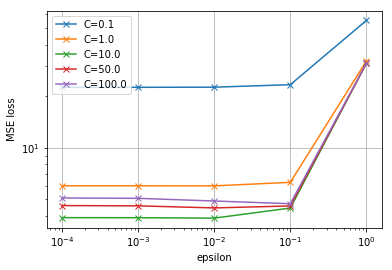

In [9]:
for C in np.unique([p['C'] for p in params]):
    pars = [p for p in params if p['C'] == C]
    x = [p['epsilon'] for p in pars]
    y = [p['l2_loss'] for p in pars]

    plt.loglog(x, y, 'x-', label="C=%0.1f" % (C))
    
plt.xlabel('epsilon')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()